In [1]:
import requests
import mercantile
from io import StringIO
from urllib.parse import urlparse, parse_qsl, urlencode, urlunparse
from affine import Affine
from shapely.geometry import shape, box, mapping, Polygon
from shapely.ops import cascaded_union
import xml.etree.ElementTree as ET
from rasterio.io import MemoryFile
from rasterio import features
import numpy as np
from rasterio.features import sieve
from shapely.ops import transform
from pyproj import Transformer, CRS
import json
import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch
from scipy.ndimage.filters import gaussian_filter
from ipywidgets import interact, interactive, FloatSlider, interact_manual, HTML
import warnings
warnings.simplefilter("ignore")


style = """
    <style>
        .output_scroll {
            height: unset !important;
            border-radius: unset !important;
            -webkit-box-shadow: unset !important;
            box-shadow: unset !important;
        }
    </style>
    """
display(HTML(style))

%matplotlib inline

HTML(value='\n    <style>\n        .output_scroll {\n            height: unset !important;\n            border…

Enter URL: E.g. https://wms.zh.ch/OGDOrthoZH?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&STYLES=&LAYERS=ortho&FORMAT=image/jpeg&CRS={proj}&WIDTH={width}&HEIGHT={height}&BBOX={bbox}

https://wms.zh.ch/OGDOrthoZH?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&STYLES=&LAYERS=ortho&FORMAT=image/jpeg&CRS={proj}&WIDTH={width}&HEIGHT={height}&BBOX={bbox}

Enter Zoom level: E.g. 10

10
Send request to: https://wms.zh.ch/OGDOrthoZH?service=WMS&request=GetCapabilities&version=1.3.0
Send request to https://wms.zh.ch/OGDOrthoZH?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&STYLES=&LAYERS=ortho&FORMAT=image/jpeg&CRS=EPSG:4326&WIDTH=512&HEIGHT=512&BBOX=47.754097979680026,8.0859375,47.98992166741417,8.4375
Send request to https://wms.zh.ch/OGDOrthoZH?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&STYLES=&LAYERS=ortho&FORMAT=image/jpeg&CRS=EPSG:4326&WIDTH=512&HEIGHT=512&BBOX=47.51720069783939,8.0859375,47.754097979680026,8.4375
Send request to https://wms.zh.ch/OGDOrthoZH?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&STYLES=&

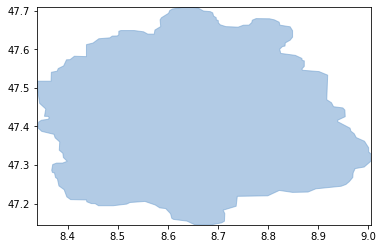

GeoJSON output:
{
    "type": "Polygon",
    "coordinates": [
        [
            [
                8.969565987549165,
                47.27922900257082
            ],
            [
                8.973652061631208,
                47.290534195958585
            ],
            [
                8.991620623576104,
                47.29457086136035
            ],
            [
                9.005352031243234,
                47.30990758297694
            ],
            [
                9.006038422582417,
                47.32756532234069
            ],
            [
                9.000676912362332,
                47.333805471963935
            ],
            [
                9.000545281887767,
                47.34476201996809
            ],
            [
                8.992305974992021,
                47.361493894815304
            ],
            [
                8.975849481486328,
                47.37098348005585
            ],
            [
                8.97170644523

In [2]:
print("Enter URL: E.g. https://wms.zh.ch/OGDOrthoZH?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&STYLES=&LAYERS=ortho&FORMAT=image/jpeg&CRS={proj}&WIDTH={width}&HEIGHT={height}&BBOX={bbox}")
print("")
url = input()
print("")
print("Enter Zoom level: E.g. 10")
print("")
zoom = int(input())

def process_tile(tile, projs):
    """ Extract geometry from area covered by tile """
    parameters = {}
    if 'EPSG:4326' in projs:
        parameters['proj'] = 'EPSG:4326'
    elif 'EPSG:3857' in projs:
        parameters['proj'] = 'EPSG:3857'
    else:
        for proj in projs:
            try:
                CRS.from_string(proj)
            except Exception as e:
                print(str(e))
                continue
            parameters['proj'] = proj
            break
    if 'proj' not in parameters:
        raise RuntimeError("No support for available projections.")

    bounds = mercantile.bounds(*tile)
    if parameters['proj'] == 'EPSG:4326' and '1.3.0' in url:
        bbox = ",".join(map(str, (bounds.south, bounds.west, bounds.north, bounds.east)))
    elif parameters['proj'] == 'EPSG:4326':
        bbox = ",".join(map(str, (bounds.west, bounds.south, bounds.east, bounds.north)))
    else:
        proj_transformer = Transformer.from_crs("epsg:4326", parameters['proj'], always_xy=True)
        bl = proj_transformer.transform(bounds.west, bounds.south)
        tr = proj_transformer.transform(bounds.east, bounds.north)
        bbox = ",".join(map(str, bl + tr))

    parameters['bbox'] = bbox

    parameters['width'] = 512
    parameters['height'] = 512
    query_url = url.format(**parameters)
    print("Send request to", query_url)

    pixel_x = (bounds.east - bounds.west) / parameters['width']
    pixel_y = (bounds.north - bounds.south) / parameters['height']
    geotransform = (bounds.west, pixel_x, 0, bounds.north, 0, -pixel_y)

    r = requests.get(query_url)
    data = r.content
    with MemoryFile(data) as memfile:
        with memfile.open() as dataset:
            data = np.zeros(shape=(dataset.height, dataset.width))
            for band in range(dataset.count):
                data += dataset.read(band + 1)

            # Convert extrema to 0
            data[data < 2] = 0
            data[data > 254] = 0

            # Blur data to avoid holes
            data = gaussian_filter(data, sigma=3)

            # Convert other pixels to 1
            data[data > 0] = 1

            # Filter small areas
            data = sieve(data.astype(np.uint8),
                         size=int(dataset.height * dataset.width * 0.001),
                         connectivity=8)

            # Create shapes for all areas with value = 1
            shapes = list(features.shapes(data.astype(np.uint8), transform=Affine.from_gdal(*geotransform)))
            buffer_dist = max(pixel_x, pixel_y) * 5
            geoms = [shape(s[0]).buffer(buffer_dist).buffer(-buffer_dist)
                     for s in shapes if int(s[1]) == 1]
            return geoms


def parse_wms(xml):
    """ Rudimentary parsing of WMS Layers from GetCapabilites Request
        owslib.wms seems to have problems parsing some weird not relevant metadata.
        This function aims at only parsing relevant layer metadata
    """
    wms = {}
    # Remove prefixes to make parsing easier
    # From https://stackoverflow.com/questions/13412496/python-elementtree-module-how-to-ignore-the-namespace-of-xml-files-to-locate-ma
    try:
        it = ET.iterparse(StringIO(xml))
        for _, el in it:
            _, _, el.tag = el.tag.rpartition('}')
        root = it.root
    except:
        raise RuntimeError("Could not parse XML.")

    root_tag = root.tag.rpartition("}")[-1]
    if root_tag in {'ServiceExceptionReport', 'ServiceException'}:
        raise RuntimeError("WMS service exception")

    if root_tag not in {'WMT_MS_Capabilities', 'WMS_Capabilities'}:
        raise RuntimeError("No Capabilities Element present: Root tag: {}".format(root_tag))

    if 'version' not in root.attrib:
        raise RuntimeError("WMS version cannot be identified.")
    version = root.attrib['version']
    wms['version'] = version

    layers = {}

    def parse_layer(element, crs=set(), styles={}, bbox=None):
        new_layer = {'CRS': crs,
                     'Styles': {},
                     'BBOX': bbox}
        new_layer['Styles'].update(styles)
        for tag in ['Name', 'Title', 'Abstract']:
            e = element.find("./{}".format(tag))
            if e is not None:
                new_layer[e.tag] = e.text
        for tag in ['CRS', 'SRS']:
            es = element.findall("./{}".format(tag))
            for e in es:
                new_layer["CRS"].add(e.text.upper())
        for tag in ['Style']:
            es = element.findall("./{}".format(tag))
            for e in es:
                new_style = {}
                for styletag in ['Title', 'Name']:
                    el = e.find("./{}".format(styletag))
                    if el is not None:
                        new_style[styletag] = el.text
                new_layer["Styles"][new_style['Name']] = new_style
        # WMS Version 1.3.0
        e = element.find("./EX_GeographicBoundingBox")
        if e is not None:
            bbox = [float(e.find("./{}".format(orient)).text.replace(',', '.'))
                    for orient in ['westBoundLongitude',
                                   'southBoundLatitude',
                                   'eastBoundLongitude',
                                   'northBoundLatitude']]
            new_layer['BBOX'] = bbox
        # WMS Version < 1.3.0
        e = element.find("./LatLonBoundingBox")
        if e is not None:
            bbox = [float(e.attrib[orient].replace(',', '.')) for orient in ['minx', 'miny', 'maxx', 'maxy']]
            new_layer['BBOX'] = bbox

        if 'Name' in new_layer:
            layers[new_layer['Name']] = new_layer

        for sl in element.findall("./Layer"):
            parse_layer(sl,
                        new_layer['CRS'].copy(),
                        new_layer['Styles'],
                        new_layer['BBOX'])

    # Find child layers. CRS and Styles are inherited from parent
    top_layers = root.findall(".//Capability/Layer")
    for top_layer in top_layers:
        parse_layer(top_layer)

    wms['layers'] = layers

    # Parse formats
    formats = []
    for es in root.findall(".//Capability/Request/GetMap/Format"):
        formats.append(es.text)
    wms['formats'] = formats

    # Parse access constraints and fees
    constraints = []
    for es in root.findall(".//AccessConstraints"):
        constraints.append(es.text)
    fees = []
    for es in root.findall(".//Fees"):
        fees.append(es.text)
    wms['Fees'] = fees
    wms['AccessConstraints'] = constraints

    return wms


def get_wms(wms_url):
    wms_args = {}
    u = urlparse(wms_url)
    url_parts = list(u)
    for k, v in parse_qsl(u.query):
        wms_args[k.lower()] = v

    def get_getcapabilitie_url(wms_version=None):

        get_capabilities_args = {'service': 'WMS',
                                 'request': 'GetCapabilities'}
        if wms_version is not None:
            get_capabilities_args['version'] = wms_version

        # Keep extra arguments, such as map or key
        for key in wms_args:
            if key not in {'version', 'request', 'layers', 'bbox', 'width', 'height', 'format', 'crs', 'srs'}:
                get_capabilities_args[key] = wms_args[key]

        url_parts[4] = urlencode(list(get_capabilities_args.items()))
        return urlunparse(url_parts)

    wms = None
    for wmsversion in ['1.3.0', '1.1.1', '1.1.0', '1.0.0', None]:
        url = get_getcapabilitie_url(wms_version=wmsversion)
        try:
            print("Send request to: {}".format(url))
            r = requests.get(url)
            xml = r.text
            wms = parse_wms(xml)
            break
        except Exception as e:
            print(str(e))
    if not wms:
        print("Could not contact WMS server")
    return wms


def simplify(geom, distance=200):
    """ Simplify geometry in epsg:3857"""
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857")
    transformer_back = Transformer.from_crs("epsg:3857", "epsg:4326")
    geom_3857 = transform(transformer.transform, geom)
    geom_3857_simplified = geom_3857.simplify(distance, preserve_topology=False)
    geom_simplified = transform(transformer_back.transform, geom_3857_simplified)
    return geom_simplified


def get_bounding_box(url):
    wms = get_wms(url)
    wms_args = {}
    u = urlparse(url)
    for k, v in parse_qsl(u.query):
        wms_args[k.lower()] = v
    layers = wms_args['layers'].split(',')
    bbox = box(*wms['layers'][layers[0]]['BBOX'])
    projs = wms['layers'][layers[0]]['CRS']
    for layer in layers[1:]:
        bbox = cascaded_union([bbox, wms['layers'][layer]['BBOX']])
        projs = projs & wms['layers'][layer]['CRS']
    return bbox, projs


bbox, projs = get_bounding_box(url)

geoms = []
tiles = list(mercantile.tiles(west=bbox.bounds[0],
                              south=bbox.bounds[1],
                              east=bbox.bounds[2],
                              north=bbox.bounds[3],
                              zooms=zoom))

for tile in tiles:
    tile_geoms = process_tile(tile, projs)
    if len(tile_geoms) > 0:
        geoms.extend(tile_geoms)

geom = cascaded_union(geoms)
geom = simplify(geom)


def plot_geometry(geom):
    bounds = geom.bounds
    fig, ax = plt.subplots()
    if isinstance(geom, Polygon):
        geom = [geom]
    for g in geom:
        patch = PolygonPatch(g, facecolor='#6699cc', edgecolor='#6699cc',
                             alpha=0.5, zorder=2)
        ax.add_patch(patch)
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    plt.show()

print("Extracted the following geometry:")
plot_geometry(geom)

print("GeoJSON output:")
print(json.dumps(mapping(geom), indent=4))
